# Australian Weather Forecasting - Imputing Data

## Import libraries

In [75]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import itertools
import matplotlib.pyplot as plt
import scipy.stats as scistat
import arviz as az
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [76]:
weather = pd.read_csv("weatherAUS.csv")
weather = weather.sample(3000)

### Filter out numeric and categorical data

In [77]:
col_list = list()
categorical = ["Date","Location","WindGustDir","WindDir9am","WindDir3pm","RainToday","RainTomorrow"]
for column in weather.columns:
    if column not in categorical:
        col_list.append(column)
numeric_data = weather[col_list]
cat_data = weather[categorical]

### Analyze Missing Data

In [78]:
def missing_data(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df
missing_data(weather)

,column_name,percent_missing
Date,Date,0.000000
Location,Location,0.000000
MinTemp,MinTemp,0.433333
MaxTemp,MaxTemp,0.300000
Rainfall,Rainfall,0.866667
Evaporation,Evaporation,40.866667
Sunshine,Sunshine,46.566667
WindGustDir,WindGustDir,6.700000
WindGustSpeed,WindGustSpeed,6.633333
WindDir9am,WindDir9am,6.900000


## Impute Numeric data and standardization
Filling missing data with the mean of our observations

In [79]:
numeric_data = numeric_data.drop(['Cloud9am','Cloud3pm','Evaporation','Sunshine'],axis=1)
numeric_data = numeric_data.apply(lambda x: x.fillna(x.mean()),axis=1)


In [80]:
numeric_data = (numeric_data - numeric_data.mean()) / (numeric_data.std())


## Impute Categorical Data
Fill missing data based on the distribution of the observed (non-missing) data

In [81]:
def impute_missing_categorical(column):
    priors = cat_data[column].value_counts()/cat_data[column].value_counts().sum()
    prior_name = priors.index
    return np.random.choice(prior_name, p=priors)

cat_data = cat_data.apply(lambda x: x.fillna(impute_missing_categorical(x.name)),axis=0)
missing_data(cat_data)

,column_name,percent_missing
Date,Date,0.0
Location,Location,0.0
WindGustDir,WindGustDir,0.0
WindDir9am,WindDir9am,0.0
WindDir3pm,WindDir3pm,0.0
RainToday,RainToday,0.0
RainTomorrow,RainTomorrow,0.0


In [82]:
missing_data(pd.concat([numeric_data,cat_data],axis=1))

,column_name,percent_missing
MinTemp,MinTemp,0.0
MaxTemp,MaxTemp,0.0
Rainfall,Rainfall,0.0
WindGustSpeed,WindGustSpeed,0.0
WindSpeed9am,WindSpeed9am,0.0
WindSpeed3pm,WindSpeed3pm,0.0
Humidity9am,Humidity9am,0.0
Humidity3pm,Humidity3pm,0.0
Pressure9am,Pressure9am,0.0
Pressure3pm,Pressure3pm,0.0


### Dataset named aussyRain

In [83]:
aussy_Rain = pd.concat([numeric_data,cat_data],axis=1)

### Convert our Date column into datetime object

In [84]:
aussy_Rain['Date']=pd.to_datetime(aussy_Rain['Date'])

### Convert Date into Season 
Thanks to https://stackoverflow.com/questions/44124436/python-datetime-to-season 

In [85]:
[(month%12 + 3)//3 for month in range(1, 13)]

[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

Where, in Australia: http://www.bom.gov.au/climate/glossary/seasons.shtml  
* Month 1 = Summer
* Month 2 = Autumn
* Month 3 = Winter
* Month 4 = Spring

In [86]:
aussy_Rain['Date'] = (aussy_Rain.Date.dt.month%12 + 3)//3

In [87]:
aussy_Rain['Date']

5403      1
122868    4
42137     1
67950     4
79611     3
         ..
69221     1
124713    3
120247    4
64832     1
7378      2
Name: Date, Length: 3000, dtype: int64

### Dummy encoding for other Categoricals

In [88]:
encoding = dict()
for column in aussy_Rain:
    if aussy_Rain[column].dtype == object:
        unique = aussy_Rain[column].unique()
        encoding[column] = {name: index for index, name in enumerate(unique)}
encoding

{'Location': {'BadgerysCreek': 0,
  'SalmonGums': 1,
  'Wollongong': 2,
  'Melbourne': 3,
  'Dartmoor': 4,
  'Tuggeranong': 5,
  'PerthAirport': 6,
  'NorfolkIsland': 7,
  'WaggaWagga': 8,
  'Brisbane': 9,
  'Walpole': 10,
  'Darwin': 11,
  'Townsville': 12,
  'CoffsHarbour': 13,
  'Bendigo': 14,
  'Launceston': 15,
  'Sydney': 16,
  'Perth': 17,
  'Uluru': 18,
  'Penrith': 19,
  'NorahHead': 20,
  'Woomera': 21,
  'GoldCoast': 22,
  'Adelaide': 23,
  'Cobar': 24,
  'Richmond': 25,
  'Portland': 26,
  'Mildura': 27,
  'Nhil': 28,
  'SydneyAirport': 29,
  'Sale': 30,
  'PearceRAAF': 31,
  'AliceSprings': 32,
  'Moree': 33,
  'Cairns': 34,
  'Witchcliffe': 35,
  'Newcastle': 36,
  'MelbourneAirport': 37,
  'MountGambier': 38,
  'MountGinini': 39,
  'Albury': 40,
  'Katherine': 41,
  'Watsonia': 42,
  'Nuriootpa': 43,
  'Albany': 44,
  'Canberra': 45,
  'Ballarat': 46,
  'Williamtown': 47,
  'Hobart': 48},
 'WindGustDir': {'N': 0,
  'W': 1,
  'S': 2,
  'SSW': 3,
  'SE': 4,
  'NE': 5,
  'E

In [89]:
aussy_Rain = aussy_Rain.replace(encoding)

Remove RISK_MM (kaggle dataset authors say this variable should be removed)

In [90]:
aussy_Rain = aussy_Rain.drop(['RISK_MM'], axis=1)

Visualize model with priors

logp = -1,419.7, ||grad|| = 0.65148: 100%|███| 247/247 [00:02<00:00, 92.16it/s]


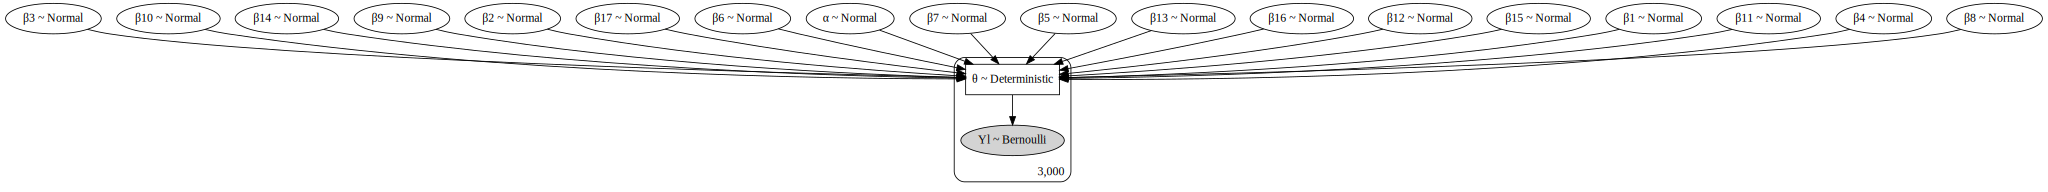

In [91]:
#### Posterior Distribution of parameters# Use pm.find_MAP() to find the maximum a-posteriori (MAP) estimate for the vector of regression coefficients .

with pm.Model() as manual_logistic_model:
    Y = aussy_Rain["RainTomorrow"]
    α = pm.Normal('α', mu=0, sd=100) 
    β1 = pm.Normal('β1', mu=0, sd=100) 
    β2 = pm.Normal('β2', mu=0, sd=100) 
    β3 = pm.Normal('β3', mu=0, sd=100) 
    β4 = pm.Normal('β4', mu=0, sd=100)
    β5 = pm.Normal('β5', mu=0, sd=100) 
    β6 = pm.Normal('β6', mu=0, sd=100)
    β7 = pm.Normal('β7', mu=0, sd=100) 
    β8 = pm.Normal('β8', mu=0, sd=100)
    β9 = pm.Normal('β9', mu=0, sd=100)
    β10 = pm.Normal('β10', mu=0, sd=100)
    β11 = pm.Normal('β11', mu=0, sd=100)
    β12 = pm.Normal('β12', mu=0, sd=100)
    β13 = pm.Normal('β13', mu=0, sd=100)
    β14 = pm.Normal('β14', mu=0, sd=100)
    β15 = pm.Normal('β15', mu=0, sd=100)
    β16 = pm.Normal('β16', mu=0, sd=100)
    β17 = pm.Normal('β17', mu=0, sd=100)


    μ = α + pm.math.dot(aussy_Rain["MinTemp"], β1) + pm.math.dot(aussy_Rain["MaxTemp"],β2) + pm.math.dot(aussy_Rain["Rainfall"], β3) + pm.math.dot(aussy_Rain["WindGustSpeed"],β4) + pm.math.dot(aussy_Rain["WindSpeed9am"], β5) + pm.math.dot(aussy_Rain["WindSpeed3pm"],β6) + pm.math.dot(aussy_Rain["Humidity9am"], β7) + pm.math.dot(aussy_Rain["Humidity3pm"],β8) + pm.math.dot(aussy_Rain["Pressure9am"], β9) + pm.math.dot(aussy_Rain["Pressure3pm"], β10) + pm.math.dot(aussy_Rain["Pressure9am"], β11) + pm.math.dot(aussy_Rain["Location"], β12) + pm.math.dot(aussy_Rain["WindGustDir"],β13) + pm.math.dot(aussy_Rain["WindDir9am"],β14) + pm.math.dot(aussy_Rain["WindDir3pm"],β15) + pm.math.dot(aussy_Rain["RainToday"],β16) + pm.math.dot(aussy_Rain["Date"], β17) 
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=Y) 
    map_estimate = pm.find_MAP()
    #print(map_estimate)
pm.model_to_graphviz(manual_logistic_model)

In [92]:
map_estimate

{'α': array(-1.25524511),
 'β1': array(0.43455331),
 'β2': array(-0.50037694),
 'β3': array(0.18487319),
 'β4': array(0.18811486),
 'β5': array(0.18378693),
 'β6': array(-0.20810912),
 'β7': array(0.18412926),
 'β8': array(0.56278254),
 'β9': array(0.52343548),
 'β10': array(-1.05275003),
 'β11': array(0.52343548),
 'β12': array(-0.0015969),
 'β13': array(-0.00301243),
 'β14': array(-0.02406027),
 'β15': array(-0.00528167),
 'β16': array(0.82382532),
 'β17': array(-0.07326875),
 'θ': array([0.04267887, 0.31940579, 0.43447542, ..., 0.41648686, 0.25639598,
        0.04859334])}

In [ ]:
with pm.Model() as logistic_model:
        Y = aussy_Rain.RainTomorrow
        pm.glm.GLM.from_formula('Y ~ MinTemp + MaxTemp + Rainfall + WindGustSpeed + WindSpeed9am + WindSpeed3pm + Humidity9am + Humidity3pm + Pressure9am + Pressure3pm + Temp9am + Temp3pm + Location + WindGustDir + WindDir9am + WindDir3pm + RainToday + Date', aussy_Rain, family=pm.glm.families.Binomial())
        trace = pm.sample(1000, tune=1000, cores=4, init='adapt_diag' target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Date, RainToday, WindDir3pm, WindDir9am, WindGustDir, Location, Temp3pm, Temp9am, Pressure3pm, Pressure9am, Humidity3pm, Humidity9am, WindSpeed3pm, WindSpeed9am, WindGustSpeed, Rainfall, MaxTemp, MinTemp, Intercept]


C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

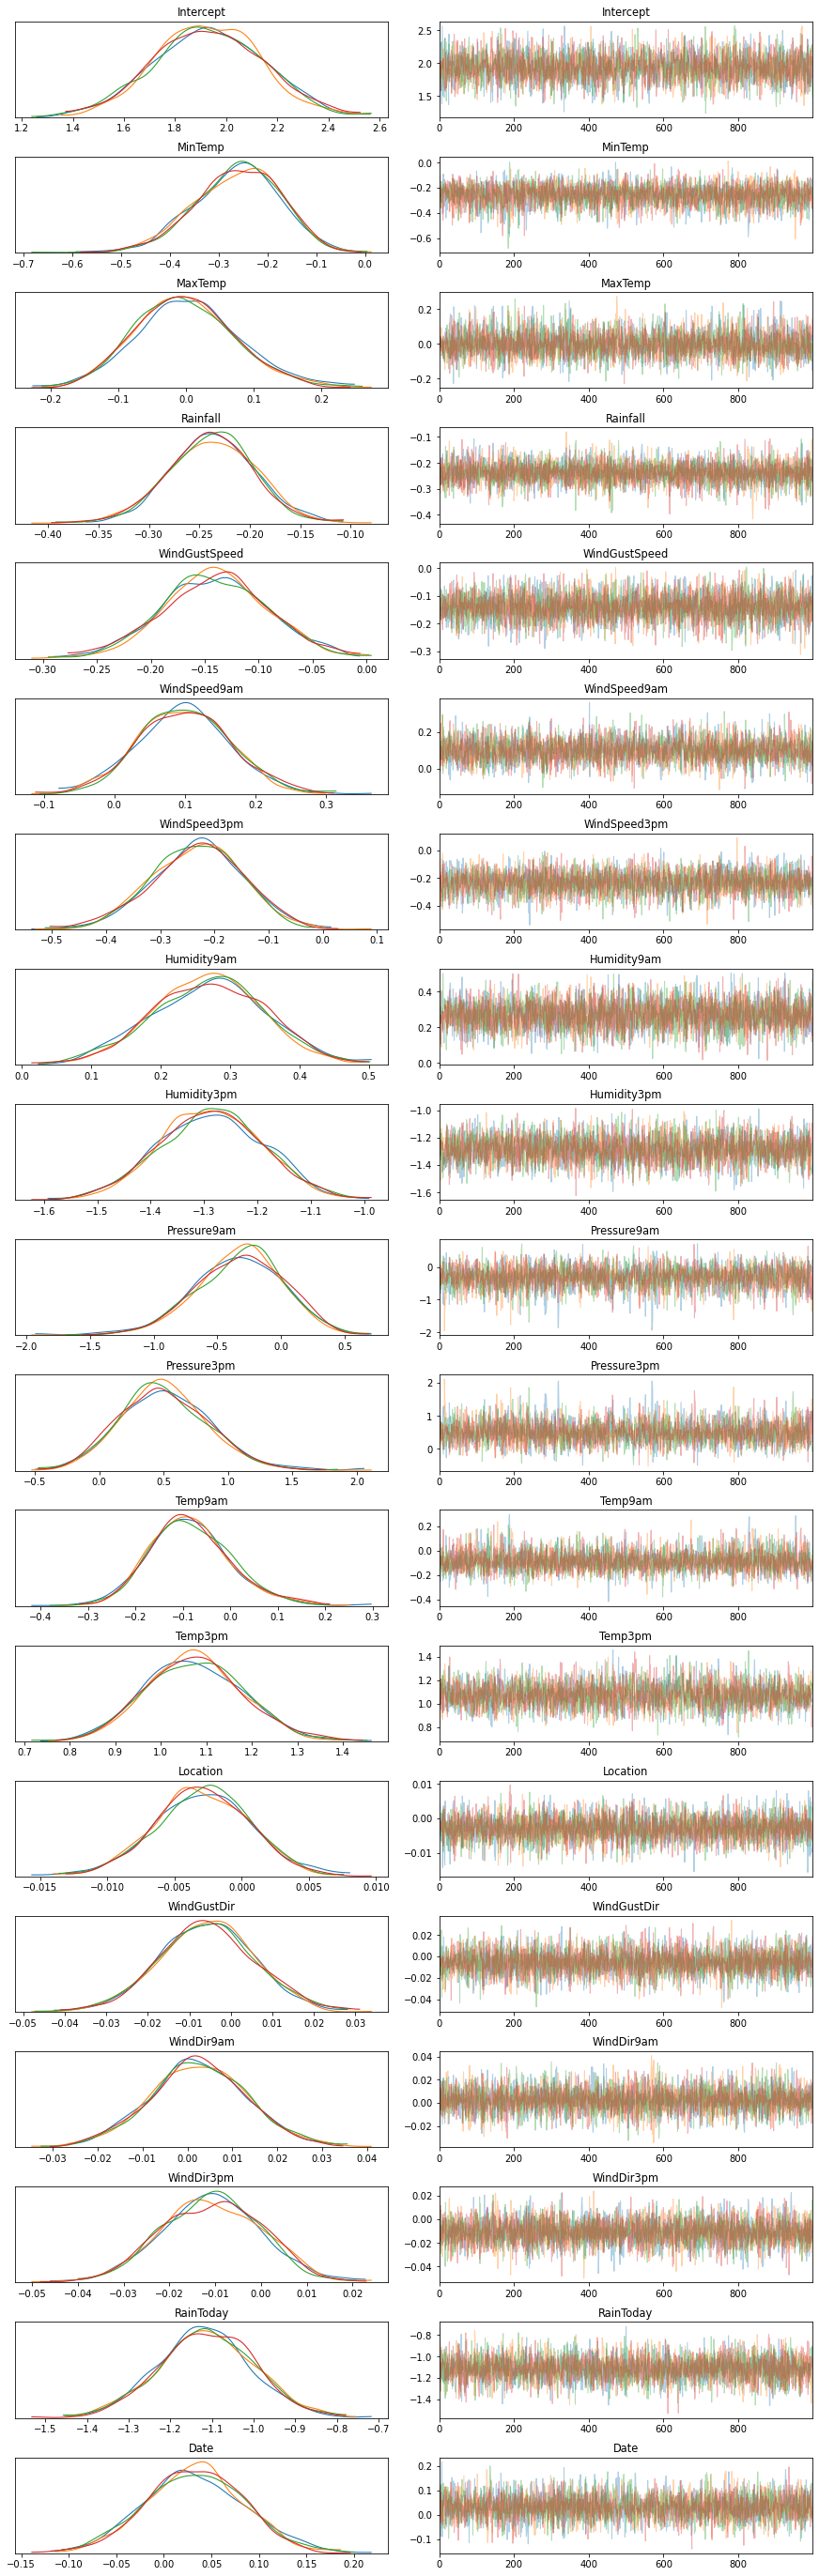

In [52]:
with pm.Model() as logistic_model:
    pm.traceplot(trace)

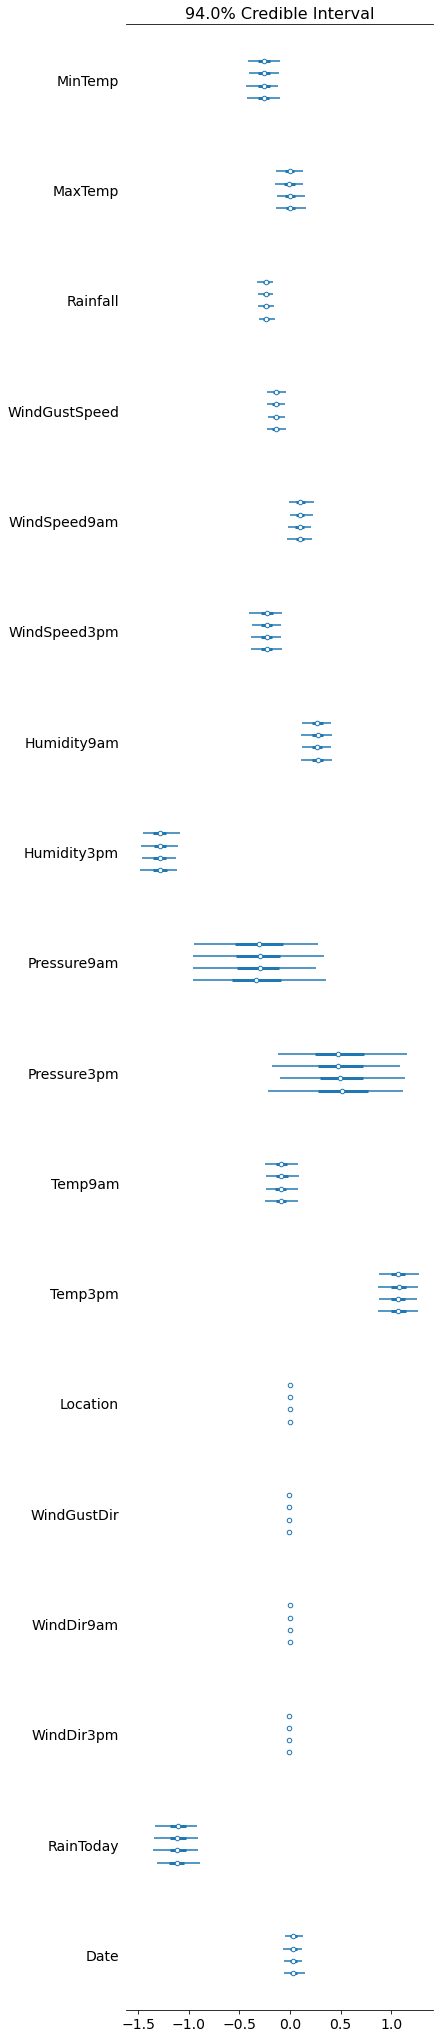

In [63]:
with pm.Model() as logistic_model:
    az.plot_forest(trace, var_names="~Intercept")

### Unpooled Model

In [64]:
Local = aussy_Rain.Location.unique()
locations = len(Local)
Location_lookup = dict(zip(Local, range(len(Local))))
location_Code = aussy_Rain['Location'] = aussy_Rain.Location.replace(Location_lookup).values 
print(aussy_Rain['Location'])

54081      0
2588       1
129379     2
44279      3
125885     4
          ..
14758      8
11954     30
31475      6
66476     47
118662    15
Name: Location, Length: 3000, dtype: int64


In [65]:
Rainfall = aussy_Rain['Rainfall']
RainTomorrow =aussy_Rain['RainTomorrow']

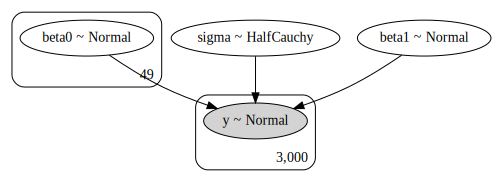

In [66]:
with pm.Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=1e5, shape=locations)
    beta1 = pm.Normal('beta1', 0, sd=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    theta = beta0[location_Code] + beta1*Rainfall
    y = pm.Normal('y', theta, sd=sigma, observed=RainTomorrow)
pm.model_to_graphviz(unpooled_model)

In [51]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, cores = 4, tune=1000)
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(unpooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|█| 8000/8000 [00:11<00:00, 675.39draws/s


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],0.69,0.05,0.60,0.79,0.0,0.0,8955.31,8695.40,9016.55,2763.15,1.00
beta0[1],0.82,0.05,0.73,0.92,0.0,0.0,11444.54,11337.62,11407.55,2921.23,1.00
beta0[2],0.87,0.05,0.79,0.96,0.0,0.0,9487.48,9487.48,9481.25,2786.05,1.00
beta0[3],0.69,0.06,0.58,0.80,0.0,0.0,9126.96,8955.95,9088.14,2841.83,1.00
beta0[4],0.69,0.06,0.59,0.81,0.0,0.0,7103.83,7103.83,7114.10,2711.16,1.00
beta0[5],0.75,0.06,0.65,0.86,0.0,0.0,9822.17,9708.79,9839.91,2929.30,1.00
beta0[6],0.75,0.05,0.65,0.84,0.0,0.0,10321.19,10321.19,10353.54,3186.15,1.00
beta0[7],0.88,0.06,0.77,0.98,0.0,0.0,9751.88,9728.63,9724.52,2561.60,1.00
beta0[8],0.68,0.05,0.57,0.77,0.0,0.0,9178.12,9178.12,9251.17,2956.72,1.00
beta0[9],0.62,0.05,0.53,0.71,0.0,0.0,9198.70,9198.70,9180.17,2463.25,1.00


C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

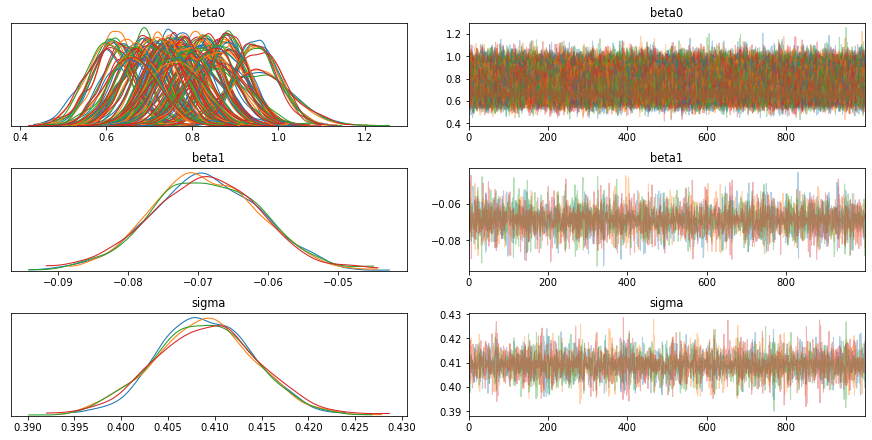

In [67]:
with unpooled_model:
    pm.traceplot(unpooled_trace)

In [68]:
estimate_unpool = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=Location_lookup)
se_unpool = pd.Series(unpooled_trace['beta0'].std(axis=0), index=Location_lookup)

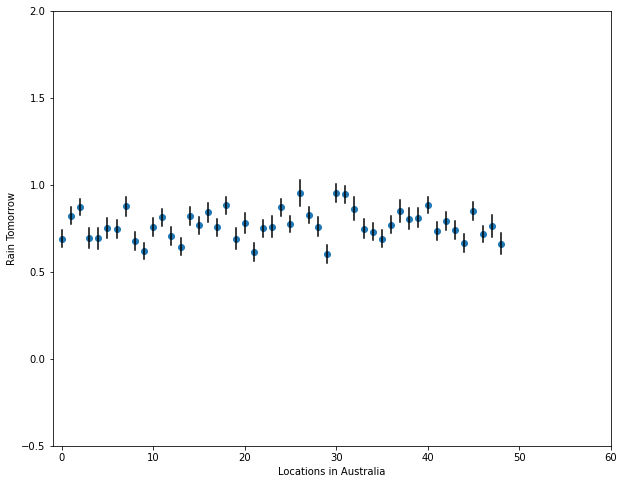

In [69]:
plt.figure(figsize = (10,8))
plt.scatter(range(len(estimate_unpool)), estimate_unpool)
for i, m, se in zip(range(len(estimate_unpool)), estimate_unpool, se_unpool):
    plt.plot([i,i], [m-se, m+se], 'black')
plt.xlim(-1,60); plt.ylim(-0.5,2)
plt.ylabel('Rain Tomorrow');plt.xlabel('Locations in Australia');

### Hierachical Model 

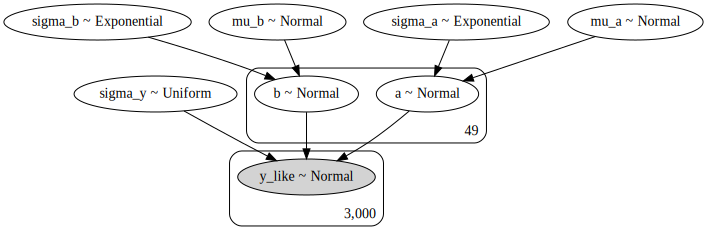

In [70]:
with pm.Model() as intercept_model:
    #Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=100)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100)
    sigma_b = pm.Exponential("sigma_b", .5)

    #Intercept, Random
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=locations)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=locations)
    #Error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    #E(X)
    y_hat = a[location_Code] + b[location_Code] * Rainfall
    #Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=RainTomorrow)
    
pm.model_to_graphviz(intercept_model)

In [71]:
with intercept_model:
    intercept_model_trace = pm.sample(3500, step = pm.NUTS(target_accept = 0.999), cores = 4, tune=1000)
    intercept_model_idata = az.from_pymc3(intercept_model_trace)
az.summary(intercept_model_idata, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains, 0 divergences: 100%|█| 18000/18000 [02:06<00:00, 141.84draws
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,0.75,0.01,0.73,0.77,0.0,0.0,7680.03,7680.03,7671.79,9359.60,1.0
mu_b,-0.24,0.04,-0.32,-0.17,0.0,0.0,4862.83,4862.83,4833.29,7606.90,1.0
a[0],0.69,0.04,0.60,0.76,0.0,0.0,12122.61,12029.31,12105.16,10272.70,1.0
a[1],0.76,0.04,0.68,0.85,0.0,0.0,10525.84,10450.37,10519.74,9824.68,1.0
a[2],0.82,0.04,0.75,0.89,0.0,0.0,13123.80,13053.88,13155.37,9799.67,1.0
...,...,...,...,...,...,...,...,...,...,...,...
b[47],-0.08,0.02,-0.12,-0.04,0.0,0.0,13799.41,13598.51,13795.74,10604.75,1.0
b[48],-0.00,0.04,-0.07,0.07,0.0,0.0,16453.31,7614.43,16437.47,11082.17,1.0
sigma_a,0.07,0.01,0.05,0.09,0.0,0.0,4904.34,4904.34,4810.32,6743.63,1.0
sigma_b,0.21,0.04,0.14,0.27,0.0,0.0,3362.30,3362.30,3310.50,6201.41,1.0


In [74]:
with intercept_model:
    pm.traceplot(intercept_model_trace)

AttributeError: __enter__